In [1]:
import numpy as np
import matplotlib.pyplot as plt

from thermoextrap.ig import IGmodel
from thermoextrap.xtrapy.models import InterpModel
from thermoextrap.xtrapy import xpan_beta


# old method

In [2]:
from thermoextrap.xtrapy import recursive_interp

In [3]:
betavals = np.arange(0.1, 10.0, 0.5)
mIG = IGmodel(nParticles=1000)


Interpolating from points 0.100000 and 9.600000
Recursion depth on this branch: 0
Maximum bootstrapped error within interval: 0.006693
Selected new extrapolation point: 4.753061


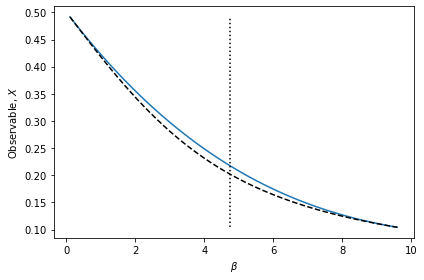


Interpolating from points 0.100000 and 4.753061
Recursion depth on this branch: 1
Maximum bootstrapped error within interval: 0.002329
No additional extrapolation points necessary on this interval.


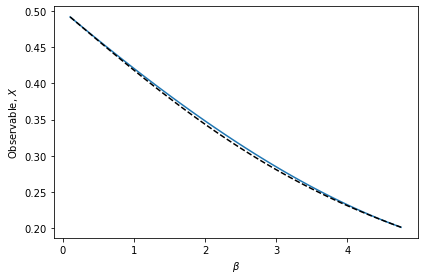


Interpolating from points 4.753061 and 9.600000
Recursion depth on this branch: 1
Maximum bootstrapped error within interval: 0.002455
No additional extrapolation points necessary on this interval.


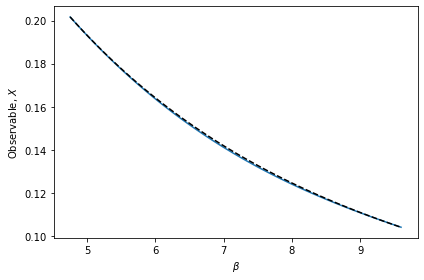

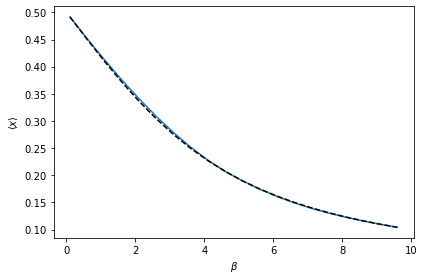

In [4]:
plt.ioff()

#Generate coefficients
derivatives = xpan_beta.factory_derivatives()

#Create the recursive model
intPpiecewise = recursive_interp.RecursiveInterp(InterpModel, derivatives,
                                                 [betavals[0], betavals[-1]],
                                                 maxOrder=1, errTol=0.003)

#Train it recursively until error tolerance reached
#Turn off verbose or doPlot if don't want to see progress of algorithm
#plotCompareFunc provides the true values to compare to in the figure
np.random.seed(42)
intPpiecewise.recursiveTrain(betavals[0], betavals[-1], verbose=True, doPlot=True, plotCompareFunc=mIG.avgX)

#Obtain predictions from our model, which will be based on piecewise interpolating polynomials
intPpredict = intPpiecewise.predict(betavals)

#Plot to compare against true average versus beta for ideal gas model
plt.ion()
interpFig, interpAx = plt.subplots()

interpAx.plot(betavals, intPpredict)
interpAx.plot(betavals, mIG.avgX(betavals), 'k--', zorder=3)

interpAx.set_ylabel(r'$\langle x \rangle$')
interpAx.set_xlabel(r'$\beta$')

interpFig.tight_layout()

plt.show()

In [5]:
intPpiecewise.sequentialTrain([2.5, 7.5], verbose=True)


Interpolating from points 0.100000 and 2.500000
Maximum bootstrapped error within interval: 0.001113
At point: 1.373469

Interpolating from points 2.500000 and 4.753061
Maximum bootstrapped error within interval: 0.001089
At point: 3.419617

Interpolating from points 4.753061 and 7.500000
Maximum bootstrapped error within interval: 0.001338
At point: 5.762141

Interpolating from points 7.500000 and 9.600000
Maximum bootstrapped error within interval: 0.000677
At point: 8.271429


Interval with edges [0.1        2.5        4.75306122] (indices [0 1 2]):
	P-values between regions:
[0.97861807 0.99906219 0.99999415 0.99999895]
	P-values for full and 1 :
[0.09494636 0.21505965 0.97540201 0.99702904]
	P-values for full and 2 :
[0.97846345 0.99887668 0.99977972 0.999881  ]
Interval with edges [2.5        4.75306122 7.5       ] (indices [1 2 3]):
	P-values between regions:
[0.37553362 0.41727297 0.41871656 0.38826451]
	P-values for full and 1 :
[0.17878952 0.21222505 0.24692956 0.26307335]
	P-values for full and 2 :
[0.31759552 0.3551746  0.37580741 0.38622669]
Interval with edges [4.75306122 7.5        9.6       ] (indices [2 3 4]):
	P-values between regions:
[0.98118809 0.98372184 0.98256629 0.97612887]
	P-values for full and 1 :
[0.43490486 0.47822385 0.5180128  0.53958755]
	P-values for full and 2 :
[0.97542167 0.9798468  0.98230479 0.98357373]


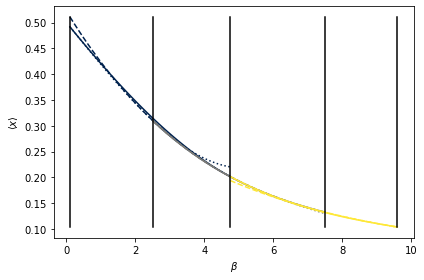

In [6]:
consist = intPpiecewise.checkPolynomialConsistency(doPlot=True)

# new interp

There are two basic adaptive interp methods. `train_iterative` adds states as long as the relative error is greater than `tol`.  A new state is inserted at an alpha value from `alphas` that is at least `alpha_tol` away from existing states.  The error is calculated over the entire `alphas` space each iteration.  If want behaviour where only two states are considered, then should pass a peicewise model, like `InterpModelPiecewise`.
    

will use the example factory_state and callback functions from adaptive_interp

In [57]:
import thermoextrap.xtrapy.models as models
import thermoextrap.xtrapy.adaptive_interp as adaptive_interp

depth: 0
alphas: [0.1, 9.6]
alpha_new: 4.6


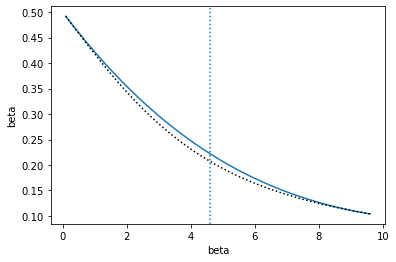

depth: 1
alphas: [0.1, 4.6, 9.6]


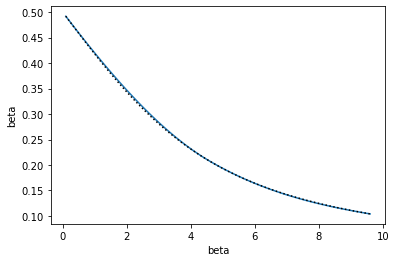

In [80]:
alphas = np.arange(betavals[0], betavals[-1] + 0.05, 0.1)
state_kws = {'order': 1, 'nrep': 100, 'rep_dim': 'rep'}

np.random.seed(20)
model_iter, info_iter = adaptive_interp.train_iterative(
    alphas=alphas, 
    factory_state=adaptive_interp.factory_state_idealgas,
    # Note: for things to be similar between this and
    # recursive, must use peicewise InterpModel
    factory_statecollection=models.InterpModelPiecewise, 
    state_kws=state_kws,
    predict_kws={'order': 1},
    reduce_dim='rep',
    alpha_tol=0.1, tol=0.003,
    callback=adaptive_interp.callback_plot_progress,
    #callback_kws={'maxdepth_stop': 2}
)
    


range0: [0.1 4.6] range1:[4.6 9.6] p01: [0.855 0.967 1.    1.   ]
range0: [0.1 4.6] range1:[0.1 9.6] p01: [0.124 0.287 1.    1.   ]
range0: [4.6 9.6] range1:[0.1 9.6] p01: [0.856 0.951 1.    1.   ]


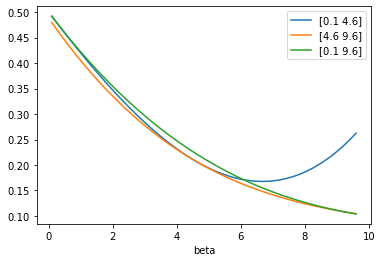

In [81]:
P, models_dict = adaptive_interp.plot_polynomial_consistency(alphas, model_iter.states, models.InterpModel)

range0: [0.1 2.5] range1:[2.5 4.6] p01: [0.906 0.983 0.999 1.   ]
range0: [0.1 2.5] range1:[0.1 4.6] p01: [0.081 0.182 0.922 0.972]
range0: [2.5 4.6] range1:[0.1 4.6] p01: [0.905 0.981 0.993 0.996]
range0: [2.5 4.6] range1:[4.6 7.5] p01: [0.644 0.434 0.151 0.103]
range0: [2.5 4.6] range1:[2.5 7.5] p01: [0.2   0.249 0.311 0.375]
range0: [4.6 7.5] range1:[2.5 7.5] p01: [0.798 0.781 0.763 0.744]
range0: [4.6 7.5] range1:[7.5 9.6] p01: [0.789 0.847 0.887 0.91 ]
range0: [4.6 7.5] range1:[4.6 9.6] p01: [0.552 0.62  0.686 0.734]
range0: [7.5 9.6] range1:[4.6 9.6] p01: [0.682 0.719 0.743 0.757]


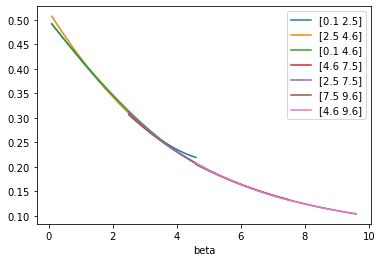

In [82]:
# add states at beta = 2.5, 7.5 to model
model_iter2 = model_iter.append([adaptive_interp.factory_state_idealgas(beta, **state_kws) for beta in [2.5, 7.5]])
_ = adaptive_interp.plot_polynomial_consistency(alphas, model_iter2.states, models.InterpModel)

# Recursive

`train_recursive` recursively adds states until relative error less than `tol`.  Only two states are ever considered when creating a model.  If no states are passes, then crate initial states at `states=[factory_state(alphas[0]), factory_state(alphas[-1])]`.  First model corresponds to `factory_statecollection([states[0], states[-1]])`.  If max error exceeds tolorence, then a new state is inserted and check call `train_recursive` in ranges `[alpha0, alpha_new]` and `[alpha_new, alpha1]` where `alpha_new` is the location of max error, and `alpha0, alpha1` are the nearest bounding values `alpha_new`.

depth: 0
alphas: [0.1, 9.6]
alpha_new: 4.6


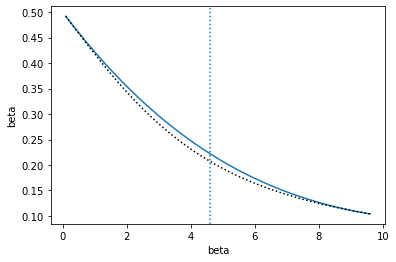

depth: 1
alphas: [0.1, 4.6]


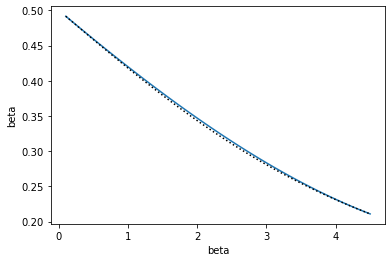

depth: 1
alphas: [4.6, 9.6]


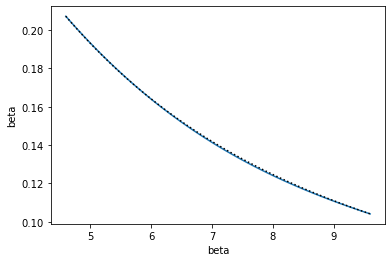

In [83]:
np.random.seed(20)
states_recurse, info_recurse = adaptive_interp.train_recursive(
    alphas=alphas,
    factory_state=adaptive_interp.factory_state_idealgas,
    factory_statecollection=models.InterpModel,
    state_kws=state_kws,
    predict_kws={'order': 1},
    reduce_dim='rep',
    alpha_tol = 0.1, tol=0.003,
    callback=adaptive_interp.callback_plot_progress,
)




In [84]:
# add in new states
states_recurse2 = sorted(
    states_recurse + [adaptive_interp.factory_state_idealgas(beta, **state_kws) for beta in [2.5, 7.5]], 
    key=lambda x: x.alpha0)

In [85]:
# the two methods should give same result
import xarray as xr
for a, b in zip(model_iter2, states_recurse2):
    xr.testing.assert_allclose(a.data.dxdu, b.data.dxdu)

range0: [0.1 2.5] range1:[2.5 4.6] p01: [0.906 0.983 0.999 1.   ]
range0: [0.1 2.5] range1:[0.1 4.6] p01: [0.081 0.182 0.922 0.972]
range0: [2.5 4.6] range1:[0.1 4.6] p01: [0.905 0.981 0.993 0.996]
range0: [2.5 4.6] range1:[4.6 7.5] p01: [0.644 0.434 0.151 0.103]
range0: [2.5 4.6] range1:[2.5 7.5] p01: [0.2   0.249 0.311 0.375]
range0: [4.6 7.5] range1:[2.5 7.5] p01: [0.798 0.781 0.763 0.744]
range0: [4.6 7.5] range1:[7.5 9.6] p01: [0.789 0.847 0.887 0.91 ]
range0: [4.6 7.5] range1:[4.6 9.6] p01: [0.552 0.62  0.686 0.734]
range0: [7.5 9.6] range1:[4.6 9.6] p01: [0.682 0.719 0.743 0.757]


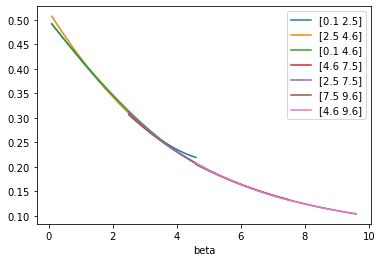

In [86]:
_ = adaptive_interp.plot_polynomial_consistency(alphas, states_recurse2, models.InterpModel)